<a href="https://colab.research.google.com/github/gauravraidata/IITJ-projects/blob/main/AAI_ASS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q1

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

np.random.seed(42)

In [29]:

class GridWorld:

    def __init__(self):
        self.size = 5
        self.start_pos = [0, 0]
        self.agent_pos = list(self.start_pos)
        self.goal_pos = [4, 4]
        self.pit_pos = [2, 4]

        self.blockade_pos = [
            [1, 0], [0, 2], [1, 2], [1, 4], [3, 2]
        ]

    def reset(self):

        while True:
            self.agent_pos = [np.random.randint(0, self.size), np.random.randint(0, self.size)]

            if (list(self.agent_pos) != self.goal_pos and
                list(self.agent_pos) != self.pit_pos and
                list(self.agent_pos) not in self.blockade_pos):
                break
        return tuple(self.agent_pos)

    def step(self, action):

        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        if action == 0:
            next_pos[0] -= 1
        elif action == 1:
            next_pos[0] += 1
        elif action == 2:
            next_pos[1] -= 1
        elif action == 3:
            next_pos[1] += 1

        if next_pos[0] < 0 or next_pos[0] >= self.size or \
           next_pos[1] < 0 or next_pos[1] >= self.size or \
           list(next_pos) in self.blockade_pos:
            return tuple(pos), -1, False

        self.agent_pos = next_pos

        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True
        else:
            return tuple(self.agent_pos), 0, False

In [30]:
class QLearningAgent:

    def __init__(self, size, alpha, gamma, epsilon):
        self.actions = [0, 1, 2, 3]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.q_table = np.zeros((size, size, len(self.actions)))

    def choose_action(self, state):

        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):

        q_predict = self.q_table[state][action]
        if done:
            q_target = reward
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        self.q_table[state][action] += self.alpha * (q_target - q_predict)

In [31]:
def plot_policy_and_value(q_table, gamma, ax_v, ax_p, env):

    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    ax_v.imshow(value_function, cmap='viridis')
    ax_v.set_title(f'Value Function (gm={gamma})')
    ax_v.set_xticks([]), ax_v.set_yticks([])

    for r in range(env.size):
        for c in range(env.size):
            if [r, c] in env.blockade_pos:
                continue

            val = value_function[r, c]
            text_color = "white" if val < (value_function.max() * 0.6) else "black"
            ax_v.text(c, r, f'{val:.1f}', ha='center', va='center', color=text_color)

    for x in range(env.size + 1):
        ax_v.axhline(x - 0.5, color='black', lw=1)
        ax_v.axvline(x - 0.5, color='black', lw=1)

    ax_v.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, fill=False, edgecolor='green', lw=3))
    ax_v.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, fill=False, edgecolor='red', lw=3))
    ax_v.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, fill=False, edgecolor='blue', lw=3))

    for r, c in env.blockade_pos:
        ax_v.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=2))

    ax_p.set_title(f'Policy (gm={gamma})')
    ax_p.imshow(np.zeros(policy.shape), cmap='gray_r', vmin=-1, vmax=1)

    for x in range(env.size + 1):
        ax_p.axhline(x - 0.5, color='black', lw=1)
        ax_p.axvline(x - 0.5, color='black', lw=1)

    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} # (dy, dx)
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            if ([r, c] != env.goal_pos and [r, c] != env.pit_pos and [r, c] not in env.blockade_pos):
                dy, dx = action_map[policy[r, c]]
                if dx != 0 or dy != 0:
                    ax_p.arrow(c, r, dx*0.4, dy*0.4, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

    ax_p.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_p.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='white', weight='bold', fontsize=12)

    ax_p.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, facecolor='blue', edgecolor='black', lw=2, alpha=0.8))
    ax_p.text(env.start_pos[1], env.start_pos[0], 'A', ha='center', va='center', color='white', weight='bold', fontsize=12)

    for r, c in env.blockade_pos:
        ax_p.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black', lw=2))

    ax_p.set_xticks([]), ax_p.set_yticks([])
    ax_p.set_ylim(env.size - 0.5, -0.5)
    ax_p.set_xlim(-0.5, env.size - 0.5)

In [32]:

def run_simulation(env, agent, episodes):

    steps_per_episode = []
    for _ in tqdm(range(episodes), desc=f"Training (gm={agent.gamma}, ep={agent.epsilon})"):
        state = env.reset()
        done = False
        steps = 0
        for _ in range(env.size * env.size * 2):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            steps += 1
            if done:
                break
        steps_per_episode.append(steps)
    return steps_per_episode

--------------------- Running simulations for Part 1 & 2: Varying Gamma ----------------------------


Training (gm=0.9, ep=0.1): 100%|██████████| 100000/100000 [00:09<00:00, 10731.24it/s]


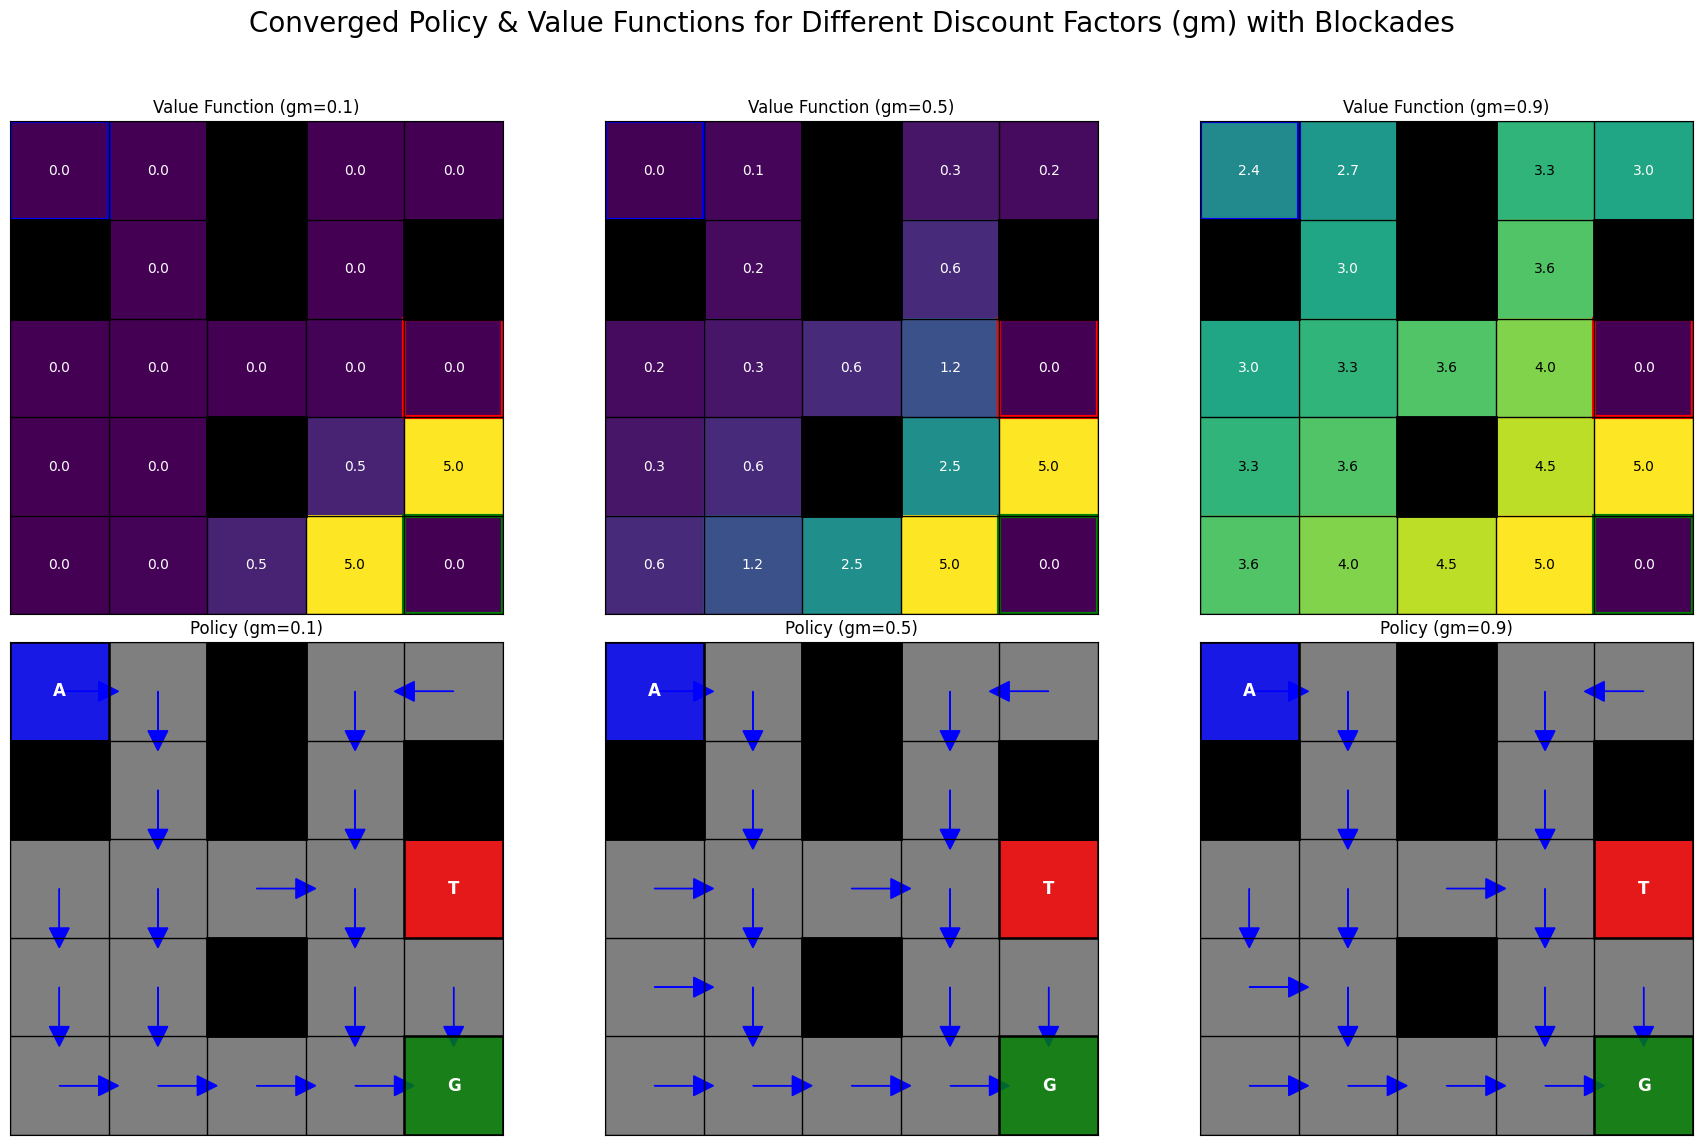


--- Running simulations for Part 3: Varying Epsilon ---


Training (gm=0.9, ep=0.5): 100%|██████████| 100000/100000 [00:20<00:00, 4969.17it/s]


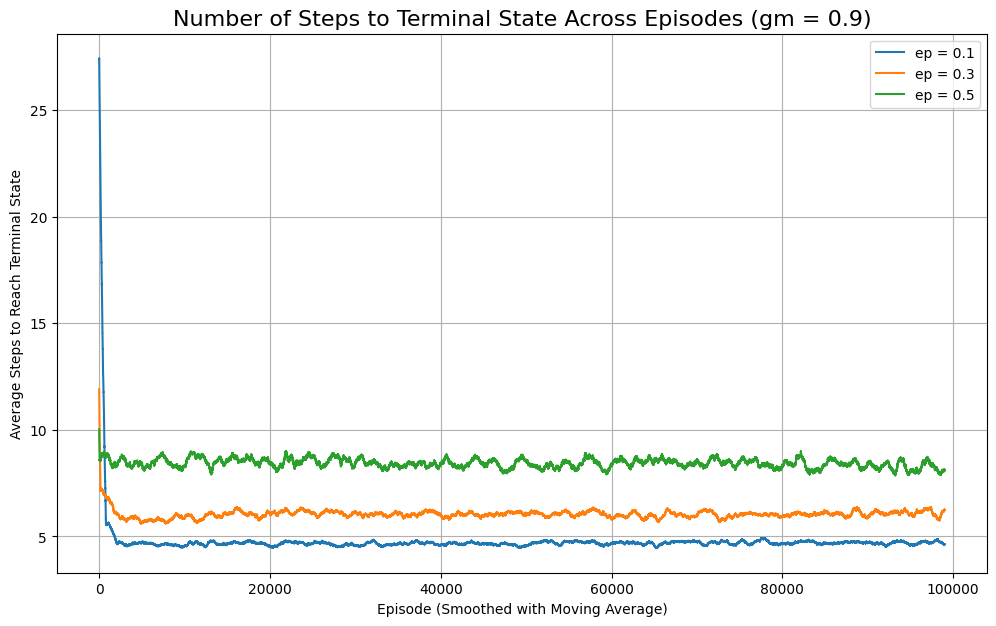

In [33]:
print("--------------------- Running simulations for Part 1 & 2: Varying Gamma ----------------------------")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Converged Policy & Value Functions for Different Discount Factors (gm) with Blockades', fontsize=20)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma, epsilon=0.1)
    run_simulation(env, agent, episodes=100000)
    plot_policy_and_value(agent.q_table, gamma, axes[0, i], axes[1, i], env)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n--- Running simulations for Part 3: Varying Epsilon ---")
epsilon_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9
plt.figure(figsize=(12, 7))

for epsilon in epsilon_values:
    env = GridWorld()
    agent = QLearningAgent(size=env.size, alpha=0.1, gamma=gamma_fixed, epsilon=epsilon)
    steps_data = run_simulation(env, agent, episodes=100000)

    window_size = 1000
    moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'ep = {epsilon}')

plt.title(f'Number of Steps to Terminal State Across Episodes (gm = {gamma_fixed})', fontsize=16)
plt.xlabel('Episode (Smoothed with Moving Average)')
plt.ylabel('Average Steps to Reach Terminal State')
plt.legend()
plt.grid(True)
plt.show()

#Q2

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

np.random.seed(42)

In [44]:

class GridWorld:

    def __init__(self):
        self.height = 5
        self.width = 11
        self.start_pos = [0, 0]
        self.agent_pos = list(self.start_pos)
        self.goal_pos = [4, 10]
        self.pit_pos = [3, 6]

        self.blockade_pos = [
            [1, 1], [0, 2], [1, 2], [0, 7], [0, 8],
            [1, 8], [2, 8], [2, 9], [3, 8]
        ]

        self.valid_states = self._create_valid_states()
        self.non_terminal_valid_states = [s for s in self.valid_states if list(s) != self.goal_pos and list(s) != self.pit_pos]


    def _create_valid_states(self):
        states = set()
        for r in range(5):
            for c in range(5):
                states.add((r, c))
        states.add((2, 5))
        for r in range(5):
            for c in range(6, 11):
                states.add((r, c))

        for block in self.blockade_pos:
            states.discard(tuple(block))

        return list(states)

    def reset(self):
        idx = np.random.choice(len(self.non_terminal_valid_states))
        self.agent_pos = list(self.non_terminal_valid_states[idx])
        return tuple(self.agent_pos)

    def step(self, action):
        pos = list(self.agent_pos)
        next_pos = list(self.agent_pos)

        if action == 0:
            next_pos[0] -= 1
        elif action == 1:
            next_pos[0] += 1
        elif action == 2:
            next_pos[1] -= 1
        elif action == 3:
            next_pos[1] += 1

        if tuple(next_pos) not in self.valid_states:
            return tuple(pos), -1, False

        self.agent_pos = next_pos

        if self.agent_pos == self.goal_pos:
            return tuple(self.agent_pos), 5, True
        elif self.agent_pos == self.pit_pos:
            return tuple(self.agent_pos), -5, True
        else:
            return tuple(self.agent_pos), 0, False

In [46]:


class QLearningAgent:
    """
    The agent that learns using Q-Learning with Softmax action selection.
    """
    def __init__(self, height, width, alpha, gamma, beta):
        self.actions = [0, 1, 2, 3]
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.q_table = np.zeros((height, width, len(self.actions)))

    def choose_action(self, state):
        """Chooses an action using a Softmax policy."""
        q_values = self.q_table[state]


        if self.beta <= 0:
            return np.argmax(q_values)


        scaled_q = q_values / self.beta

        exp_q = np.exp(scaled_q - np.max(scaled_q))
        probs = exp_q / np.sum(exp_q)

        return np.random.choice(self.actions, p=probs)

    def learn(self, state, action, reward, next_state, done):
        """Updates the Q-table using the Q-Learning update rule."""
        q_predict = self.q_table[state][action]
        if done:
            q_target = reward
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])

        self.q_table[state][action] += self.alpha * (q_target - q_predict)

In [47]:
def plot_policy_and_value(q_table, gamma, beta, ax_v, ax_p, env):

    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    mask_invalid_states = np.ones_like(value_function, dtype=bool)
    for r, c in env.valid_states:
        mask_invalid_states[r, c] = False

    cmap_vf = plt.cm.viridis
    cmap_vf.set_bad('white')
    masked_vf = np.ma.masked_array(value_function, mask=mask_invalid_states)

    ax_v.imshow(masked_vf, cmap=cmap_vf, interpolation='nearest')
    ax_v.set_facecolor('white')
    ax_v.set_title(f'Value Function (gm={gamma})')

    ax_v.set_xticks(np.arange(env.width + 1) - 0.5, minor=True)
    ax_v.set_yticks(np.arange(env.height + 1) - 0.5, minor=True)
    ax_v.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax_v.tick_params(which='minor', size=0)

    vf_valid_values = masked_vf.compressed()
    vf_min = vf_valid_values.min() if len(vf_valid_values) > 0 else 0
    vf_max = vf_valid_values.max() if len(vf_valid_values) > 0 else 0
    mid_point = vf_min + (vf_max - vf_min) * 0.5 if (vf_max - vf_min) > 0 else vf_min

    for r, c in env.valid_states:
        val = value_function[r, c]
        text_color = "white" if val < mid_point else "black"
        ax_v.text(c, r, f'{val:.1f}', ha='center', va='center', color=text_color, fontsize=6)

    ax_p.imshow(np.zeros((env.height, env.width)), cmap='Greys', vmin=0, vmax=1)
    ax_p.set_facecolor('white')
    ax_p.set_title(f'Policy (gm={gamma})')

    for ax in [ax_v, ax_p]:
        ax.set_xticks([]), ax.set_yticks([])

        ax.add_patch(mpatches.Rectangle((-0.5, -0.5), env.width, env.height,
                                        fill=False, edgecolor='black', linewidth=2))

        ax.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, facecolor='blue', edgecolor='black'))
        ax.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='black'))
        ax.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='black'))

        ax.text(env.start_pos[1], env.start_pos[0], 'A', ha='center', va='center', color='white', weight='bold', fontsize=10)
        ax.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=10)
        ax.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='white', weight='bold', fontsize=10)

        for r, c in env.blockade_pos:
            ax.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black'))

    ax_p.set_xticks(np.arange(env.width + 1) - 0.5, minor=True)
    ax_p.set_yticks(np.arange(env.height + 1) - 0.5, minor=True)
    ax_p.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax_p.tick_params(which='minor', size=0)

    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
    for r,c in env.valid_states:
        if list((r,c)) not in [env.goal_pos, env.pit_pos]:
            ax_p.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='lightgray', edgecolor='none'))
            dy, dx = action_map[policy[r, c]]
            if dx != 0 or dy != 0:
                ax_p.arrow(c, r, dx*0.35, dy*0.35, head_width=0.25, head_length=0.25, fc='black', ec='black')

In [48]:
def plot_learning_curves(steps_data, rewards_data, window_size=1000):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Agent Learning Curves', fontsize=18)

    episodes = range(len(steps_data))
    steps_moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')

    ax1.fill_between(episodes, steps_data, color="darkorange", alpha=0.4, label='Episode Steps')
    ax1.plot(range(window_size-1, len(steps_data)), steps_moving_avg, color='darkblue', linewidth=2, label=f'Moving Avg (window={window_size})')
    ax1.set_ylabel("Steps")
    ax1.set_title("Learning Curve: Steps per Episode")
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_facecolor('#f0f0f0')

    rewards_moving_avg = np.convolve(rewards_data, np.ones(window_size)/window_size, mode='valid')
    goal_reward = 5

    ax2.plot(episodes, rewards_data, color="royalblue", alpha=0.4, label='Episode Reward')
    ax2.plot(range(window_size-1, len(rewards_data)), rewards_moving_avg, color='darkred', linewidth=2, label=f'Moving Avg (window={window_size})')
    ax2.axhline(y=goal_reward, color='green', linestyle='--', linewidth=2, label='Goal Reward')

    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Total Reward")
    ax2.set_title("Learning Curve: Episode Rewards")
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.set_facecolor('#f0f0f0')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [49]:
def plot_policy_and_value(q_table, gamma, beta, ax_v, ax_p, env):
    """
    Plots the value function and policy for the complex grid, with a white
    background and A, T, G labels for Agent, Terminal, and Goal states.
    """
    value_function = np.max(q_table, axis=2)
    policy = np.argmax(q_table, axis=2)

    mask_invalid_states = np.ones_like(value_function, dtype=bool)
    for r, c in env.valid_states:
        mask_invalid_states[r, c] = False

    cmap_vf = plt.cm.viridis
    cmap_vf.set_bad('white')
    masked_vf = np.ma.masked_array(value_function, mask=mask_invalid_states)


    ax_v.imshow(masked_vf, cmap=cmap_vf, interpolation='nearest')
    ax_v.set_facecolor('white')
    ax_v.set_title(f'Value Function (gm={gamma})')

    ax_v.set_xticks(np.arange(env.width + 1) - 0.5, minor=True)
    ax_v.set_yticks(np.arange(env.height + 1) - 0.5, minor=True)
    ax_v.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax_v.tick_params(which='minor', size=0)

    vf_valid_values = masked_vf.compressed()
    vf_min = vf_valid_values.min() if len(vf_valid_values) > 0 else 0
    vf_max = vf_valid_values.max() if len(vf_valid_values) > 0 else 0
    mid_point = vf_min + (vf_max - vf_min) * 0.5 if (vf_max - vf_min) > 0 else vf_min

    for r, c in env.valid_states:
        val = value_function[r, c]
        text_color = "white" if val < mid_point else "black"
        ax_v.text(c, r, f'{val:.1f}', ha='center', va='center', color=text_color, fontsize=6)

    ax_p.imshow(np.zeros((env.height, env.width)), cmap='Greys', vmin=0, vmax=1)
    ax_p.set_facecolor('white')
    ax_p.set_title(f'Policy (gm={gamma})')

    for ax in [ax_v, ax_p]:
        ax.set_xticks([]), ax.set_yticks([])

        ax.add_patch(mpatches.Rectangle((-0.5, -0.5), env.width, env.height,
                                        fill=False, edgecolor='black', linewidth=2))

        ax.add_patch(mpatches.Rectangle((env.start_pos[1] - 0.5, env.start_pos[0] - 0.5), 1, 1, facecolor='blue', edgecolor='black'))
        ax.add_patch(mpatches.Rectangle((env.goal_pos[1] - 0.5, env.goal_pos[0] - 0.5), 1, 1, facecolor='green', edgecolor='black'))
        ax.add_patch(mpatches.Rectangle((env.pit_pos[1] - 0.5, env.pit_pos[0] - 0.5), 1, 1, facecolor='red', edgecolor='black'))

        ax.text(env.start_pos[1], env.start_pos[0], 'A', ha='center', va='center', color='white', weight='bold', fontsize=10)
        ax.text(env.goal_pos[1], env.goal_pos[0], 'G', ha='center', va='center', color='white', weight='bold', fontsize=10)
        ax.text(env.pit_pos[1], env.pit_pos[0], 'T', ha='center', va='center', color='white', weight='bold', fontsize=10)

        for r, c in env.blockade_pos:
            ax.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='black', edgecolor='black'))

    ax_p.set_xticks(np.arange(env.width + 1) - 0.5, minor=True)
    ax_p.set_yticks(np.arange(env.height + 1) - 0.5, minor=True)
    ax_p.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax_p.tick_params(which='minor', size=0)

    action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
    for r,c in env.valid_states:
        if list((r,c)) not in [env.goal_pos, env.pit_pos]:
            ax_p.add_patch(mpatches.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor='lightgray', edgecolor='none'))
            dy, dx = action_map[policy[r, c]]
            if dx != 0 or dy != 0:
                ax_p.arrow(c, r, dx*0.35, dy*0.35, head_width=0.25, head_length=0.25, fc='black', ec='black')

In [54]:
def run_simulation(env, agent, episodes):

    steps_per_episode = []
    rewards_per_episode = [] # New: To store rewards

    desc = f"Training (gm={agent.gamma}, beta={agent.beta})"
    for _ in tqdm(range(episodes), desc=desc):
        state = env.reset()
        done = False
        steps = 0
        total_reward = 0

        for _ in range(500):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.learn(state, action, reward, next_state, done)

            state = next_state
            steps += 1
            total_reward += reward

            if done:
                break

        steps_per_episode.append(steps)
        rewards_per_episode.append(total_reward)

    return steps_per_episode, rewards_per_episode

--- Running simulations for Part 1 & 2: Varying Gamma ---


Training (gm=0.9, beta=0.1): 100%|██████████| 200000/200000 [01:45<00:00, 1888.15it/s]


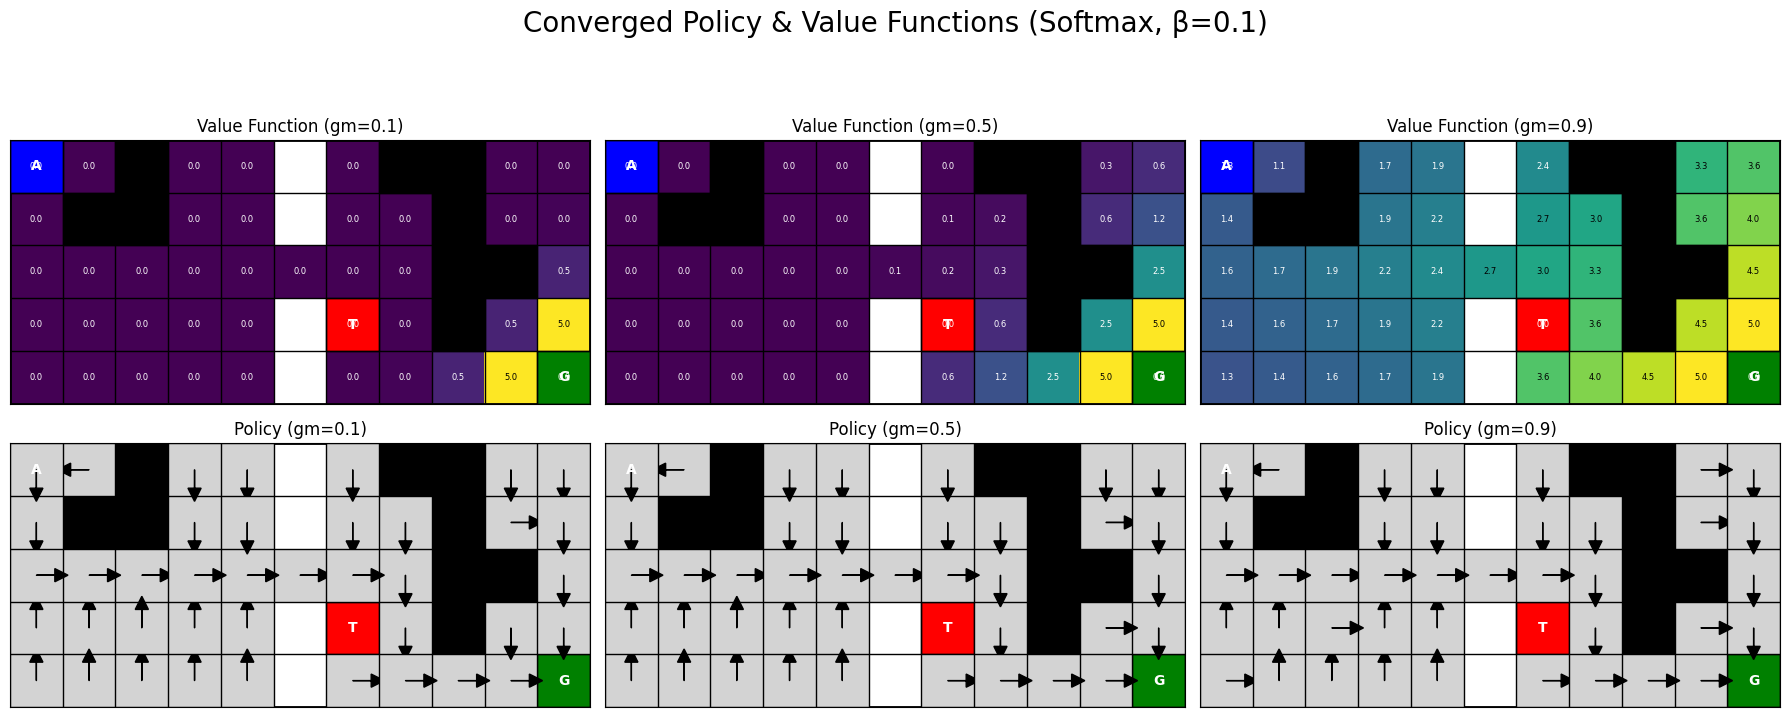

In [55]:
# ===== Cell 6: Experiment 1 - Varying Gamma =====

print("--- Running simulations for Part 1 & 2: Varying Gamma ---")
gamma_values = [0.1, 0.5, 0.9]
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Converged Policy & Value Functions (Softmax, β=0.1)', fontsize=20)

for i, gamma in enumerate(gamma_values):
    env = GridWorld()
    agent = QLearningAgent(height=env.height, width=env.width, alpha=0.1, gamma=gamma, beta=0.1)
    run_simulation(env, agent, episodes=200000)
    plot_policy_and_value(agent.q_table, gamma, 0.1, axes[0, i], axes[1, i], env)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Running simulations for Part 3: Varying Beta ---


Training (gm=0.9, beta=0.5): 100%|██████████| 200000/200000 [05:04<00:00, 656.12it/s]
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


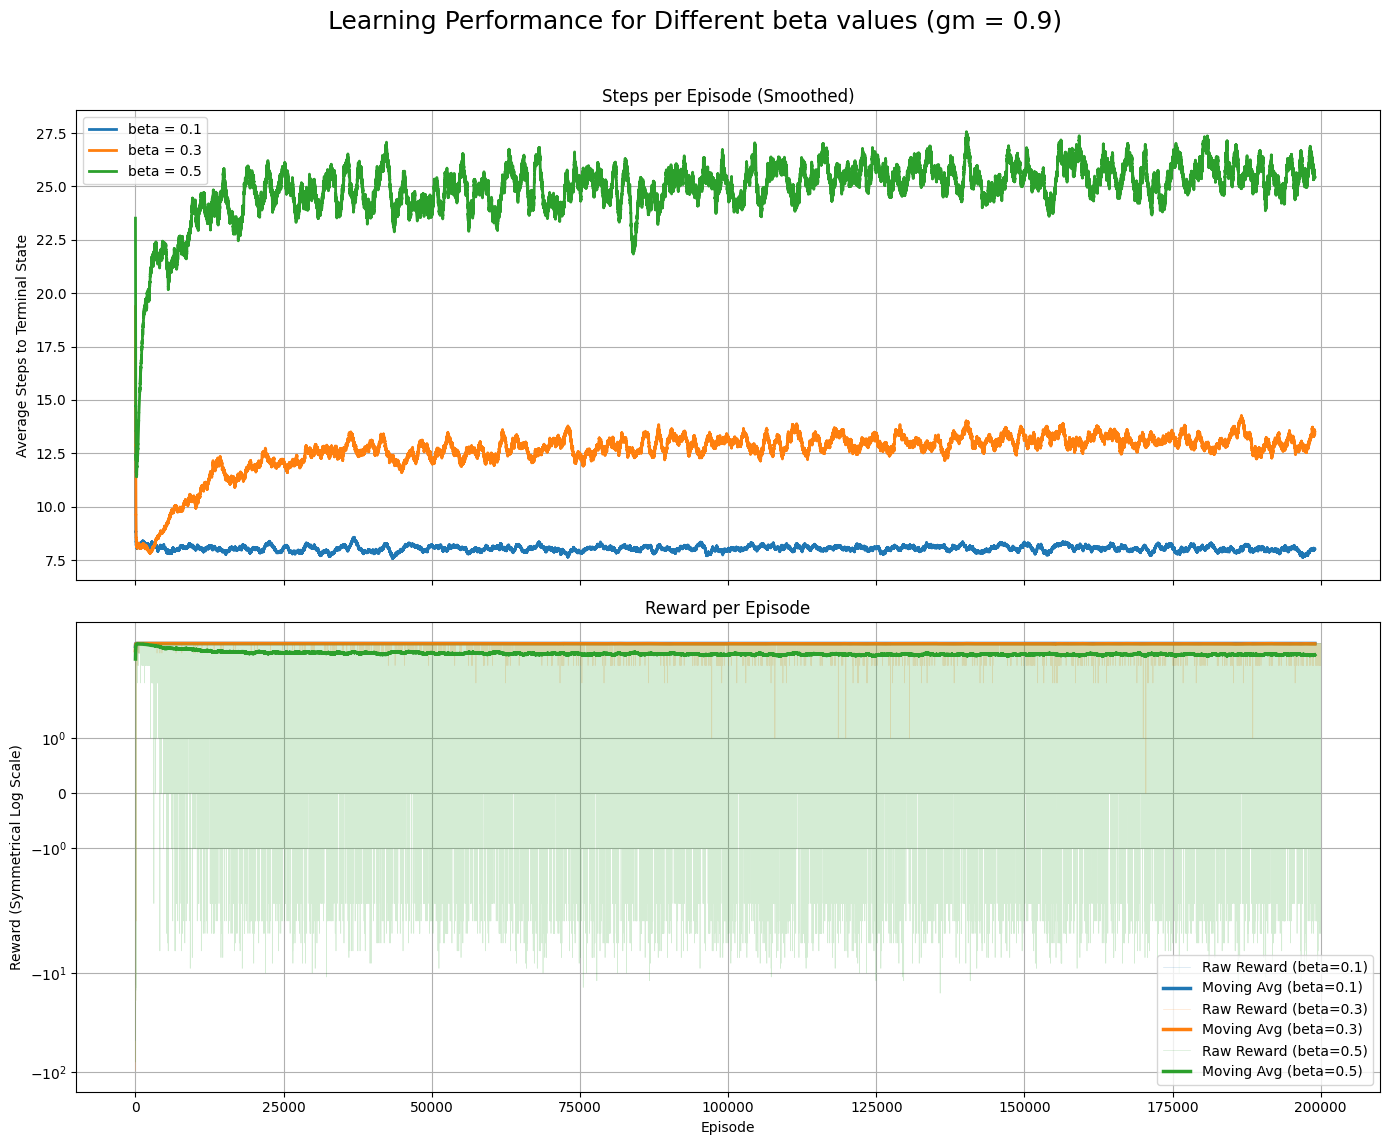

In [57]:
# ===== Cell: Experiment 2 - Varying Beta (with Logarithmic Reward Plot) =====

print("\n--- Running simulations for Part 3: Varying Beta ---")
beta_values = [0.1, 0.3, 0.5]
gamma_fixed = 0.9
episodes_to_run = 200000
window_size = 1000

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'Learning Performance for Different beta values (gm = {gamma_fixed})', fontsize=18)

# Define distinct colors for the plots
colors = {'0.1': 'C0', '0.3': 'C1', '0.5': 'C2'}

# Loop through each beta value
for beta in beta_values:
    env = GridWorld()
    agent = QLearningAgent(height=env.height, width=env.width, alpha=0.1, gamma=gamma_fixed, beta=beta)

    steps_data, rewards_data = run_simulation(env, agent, episodes=episodes_to_run)

    # --- Plot 1: Steps per Episode (Moving Average) ---
    steps_moving_avg = np.convolve(steps_data, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(steps_moving_avg, label=f'beta = {beta}', color=colors[str(beta)], linewidth=2)

    # --- Plot 2: Reward per Episode ---
    # Plot the raw reward data with high transparency
    ax2.plot(rewards_data, alpha=0.2, label=f'Raw Reward (beta={beta})', color=colors[str(beta)], linewidth=0.5)

    # Plot the smoothed moving average line on top
    rewards_moving_avg = np.convolve(rewards_data, np.ones(window_size)/window_size, mode='valid')
    ax2.plot(rewards_moving_avg, label=f'Moving Avg (beta={beta})', color=colors[str(beta)], linewidth=2.5)

# --- Finalize the Steps Plot (Top) ---
ax1.set_title('Steps per Episode (Smoothed)')
ax1.set_ylabel('Average Steps to Terminal State')
ax1.legend()
ax1.grid(True)

# --- Finalize the Rewards Plot (Bottom) ---
ax2.set_title('Reward per Episode')
ax2.set_ylabel('Reward (Symmetrical Log Scale)')
ax2.set_xlabel('Episode')

# --- THIS IS THE NEW LINE ---
# Use a symmetrical log scale to handle positive, zero, and negative rewards
ax2.set_yscale('symlog')

ax2.legend()
ax2.grid(True)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()